In [1]:
import pandas as pd
import ultraplot as pplt
import numpy as np
import pyproj

df = pd.read_csv('../data/validation_dataset_testtrain_split.csv')
df_imstats = pd.read_csv('../data/validation_dataset_image_statistics.csv')
df_imstats.rename({'region': 'case_name'}, axis=1, inplace=True)

In [3]:
# # Code for getting the centers of the shifted image
# left_x, bottom_y, right_x, top_y = f.bounds
# x0 = 0.5*(left_x + right_x)
# y0 = 0.5*(bottom_y + top_y)
# crs0 = pyproj.CRS('WGS84')
# crs1 = pyproj.CRS('epsg:3413')
# transformer_xy_ll = pyproj.Transformer.from_crs(crs1, crs_to=crs0, always_xy=True)
# bottom_left_lon, bottom_left_lat = transformer_xy_ll.transform(left_x, bottom_y)
# top_right_lon, top_right_lat = transformer_xy_ll.transform(right_x, top_y)
# center_lon, center_lat = transformer_xy_ll.transform(x0, y0)

# Using the 500 km images
* Each image contains 400 tiles. These tiles are each 25 km, and have been manually tagged as true or false based on the presence of sea ice to an expert observer. The filter algorithm should use a subset of the basic image metrics to select the "true" tiles while rejecting as many as possible of the "false" tiles.
* We can automatically reject the tiles with smaller than a given number of ocean pixels. I set the requirement at 10% ocean pixels.
* We balance the input by selecting the same number of true and false cases, then we do the test-train split.
* We compare the results for all cases, cloudy cases only, and for clear-sky cases.
* Variables are scaled by their minimum and maximum to have a range from 0 to 1. This is mainly important for the entropy, as the entropy doesn't have a strict upper bound.
* 

In [107]:
import os
# 25km_data_tables/
dataloc = '../data/validation_dataset/modis_500km/25km_data_tables/'
land_threshold = 0.90 # Reject tiles with 90% land cover; could also be size dependent

dataframes = []
for file in os.listdir(dataloc):
    if '.DS' not in file:
        df = pd.read_csv(dataloc + file,
                index_col=0)
        df['region'] = file.split('-')[1]
        idx = df.land_fraction <= land_threshold
        dataframes.append(df.loc[idx, :].copy())


In [108]:
df = pd.concat(dataframes)
idx = df.land_fraction <= land_threshold
true_cases = sum(df.loc[idx, 'ground_truth'])
false_cases = len(df.loc[idx, :]) - true_cases
n = min(true_cases, false_cases)
# Get a balanced subset of true and false cases
df_subset = df.loc[idx, :].groupby('ground_truth').apply(
    lambda x: x.sample(replace=False, n=n), include_groups=False).reset_index()
minimal_variables = ['truecolor_band_1_contrast',  'falsecolor_band_2_contrast',
                     'falsecolor_band_7_contrast', 'truecolor_band_1_entropy',
                     'falsecolor_band_2_entropy', 'falsecolor_band_7_entropy',
                     'possible_sea_ice_fraction']
for variable in minimal_variables:
    print(variable, df_subset[variable].min().round(2), df_subset[variable].max().round(2))
    df_subset[variable] = (df_subset[variable] - df_subset[variable].min()) / df_subset[variable].max()


truecolor_band_1_contrast 0.02 0.94
falsecolor_band_2_contrast 0.0 1.0
falsecolor_band_7_contrast 0.0 0.93
truecolor_band_1_entropy 0.21 7.78
falsecolor_band_2_entropy -0.0 7.88
falsecolor_band_7_entropy -0.0 7.67
possible_sea_ice_fraction 0.0 1.0


In [109]:
df_subset.groupby('region').sum()

,ground_truth,tile_index,cloud_fraction,land_fraction,truecolor_band_1_contrast,falsecolor_band_2_contrast,falsecolor_band_7_contrast,truecolor_band_1_entropy,falsecolor_band_2_entropy,falsecolor_band_7_entropy,possible_sea_ice_fraction
region,,,,,,,,,,,
baffin_bay,23,52563,188.950,84.851656,101.627513,121.168,157.326902,155.915409,162.673943,175.796931,177.856
barents_kara_seas,163,84022,277.128,42.781053,212.416931,264.517,256.891747,348.006501,364.392933,362.575151,284.850
beaufort_sea,226,116497,390.666,0.000000,152.940741,209.233,229.295820,388.963737,422.329535,435.719024,495.518
bering_chukchi_seas,239,103830,400.085,9.273404,169.974603,192.371,173.652733,364.964890,359.494880,354.615187,221.205
east_siberian_sea,59,98564,438.055,0.000000,123.053968,172.167,198.137192,331.765523,368.814990,381.083942,264.386
greenland_sea,252,108467,231.942,45.471831,200.708995,248.380,177.930332,325.965930,335.877700,309.463377,262.485
hudson_bay,536,142042,0.229,20.874588,185.786243,222.820,55.653805,322.811295,325.710387,222.012128,502.778
laptev_sea,543,118743,124.465,21.929661,137.708995,153.101,215.679528,413.100685,431.543502,481.100705,649.793
sea_of_okhostk,183,76819,5.884,47.905800,72.201058,104.937,37.337621,196.912732,186.665579,91.049736,118.630


In [110]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from skimage.measure import regionprops_table
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score

In [111]:
# scale data


# All cases

F1 score:  0.844
Recall:  0.81
Precision:  0.881
Confusion matrix:
       PredTrue  PredFalse
True       0.46       0.05
False      0.09       0.39


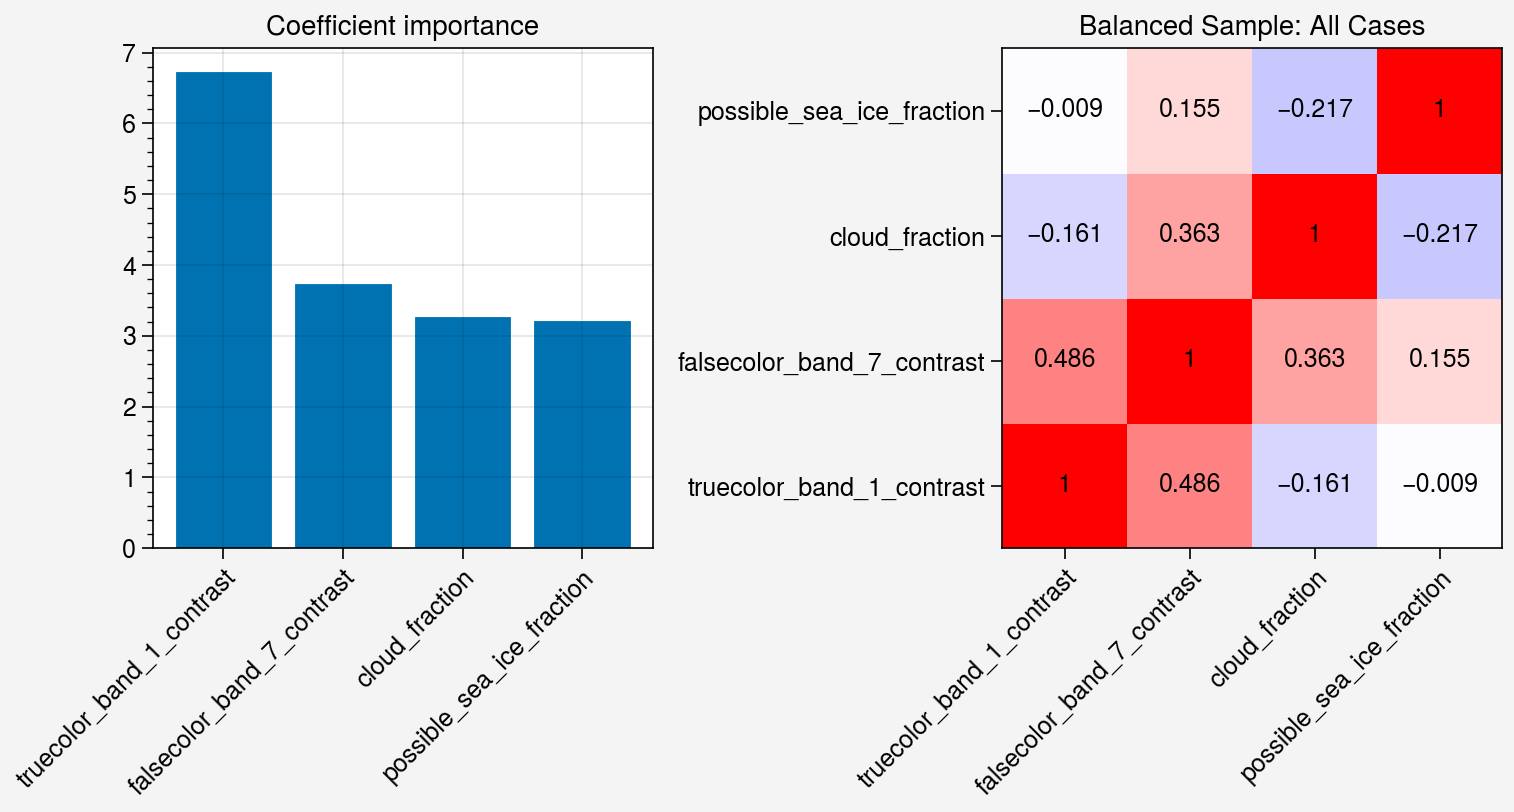

In [120]:
rs = 20250922
df_subset['cloudy_'] = df_subset['cloud_fraction'] > 0.25
#### Train logistic regression model
# Removed variables: 'falsecolor_band_2_entropy'
minimal_variables = ['truecolor_band_1_contrast',
                     #'falsecolor_band_2_contrast',
                     'falsecolor_band_7_contrast',
                     #'truecolor_band_1_entropy',
                     #'falsecolor_band_7_entropy', 
                     'cloud_fraction',
                     'possible_sea_ice_fraction']

data = df_subset.loc[:, minimal_variables + ['ground_truth']].copy()
# This are the variables that are not closely correlated with each other. Functions of other brightness channels could be useful.

X = data.loc[:, minimal_variables].to_numpy()
y =  (data.ground_truth).to_numpy()

# Split data into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=1/3, random_state=10)

# Fit the logistic regression model using cross validation
lr_model = LogisticRegressionCV(
                     solver='liblinear',
                     scoring='accuracy',
                     penalty='l1',
                     max_iter=300,
                     cv=10,
                     random_state=rs).fit(X_train, y_train)

#### Compute and print skill scores for the model
y_pred = lr_model.predict(X_test)

df_subset.loc[:, "result"] = lr_model.predict(X)
probs = lr_model.predict_proba(X)
p_false, p_true = probs[:, 0], probs[:, 1]
df_subset.loc[:,  "result_probability"] = p_true

print('F1 score: ', np.round(f1_score(y_test, y_pred), 3))
print('Recall: ', np.round(recall_score(y_test, y_pred), 3))
print('Precision: ', np.round(precision_score(y_test, y_pred), 3))
print('Confusion matrix:')
print(pd.DataFrame(data=np.round(confusion_matrix(y_test, y_pred)/len(y_test), 2),
             index=['True', 'False'], columns=['PredTrue', 'PredFalse']))

fig, axs = pplt.subplots(ncols=2, share=False)
ax = axs[0]
ax.bar(pd.Series(abs(lr_model.coef_[0]), index=minimal_variables))
ax.format(xrotation=45, title="Coefficient importance")

ax = axs[1]
ax.heatmap(df_subset.loc[:, minimal_variables].corr(), labels=True, vmin=-1, vmax=1, cmap='bwr')
ax.format(xrotation=45, title='Balanced Sample: All Cases')

lr_model

In [113]:
# 25 km images
pd.Series(lr_model.coef_[0], index=minimal_variables)

truecolor_band_1_contrast     6.724997
falsecolor_band_7_contrast   -3.736827
cloud_fraction               -3.262004
possible_sea_ice_fraction     3.208018
dtype: float64

In [114]:
# Model coefficients are different with 50 km vs 25 km images
pd.Series(lr_model.coef_[0], index=minimal_variables)

truecolor_band_1_contrast     6.724997
falsecolor_band_7_contrast   -3.736827
cloud_fraction               -3.262004
possible_sea_ice_fraction     3.208018
dtype: float64

In [115]:
lr_model.intercept_

array([-1.34236415])

In [116]:
def log_prob(truecolor_band_1_contrast,
             falsecolor_band_7_contrast,
             cloud_fraction,
             possible_sea_ice_fraction):
    intercept =  -1.32476523
    beta0 = 7.235885
    beta1 = -3.741664
    beta2 = -3.116937
    beta3 = 2.985701
    return 1 / (1 + np.exp(-(intercept + beta0 * truecolor_band_1_contrast + \
                            beta1 * falsecolor_band_7_contrast + beta2 * cloud_fraction + \
                             beta3 * possible_sea_ice_fraction)))
    

In [117]:
df_subset['test_prob'] = log_prob(df_subset['truecolor_band_1_contrast'],
                                  df_subset['falsecolor_band_7_contrast'],
                                  df_subset['cloud_fraction'],
                                  df_subset['possible_sea_ice_fraction'])

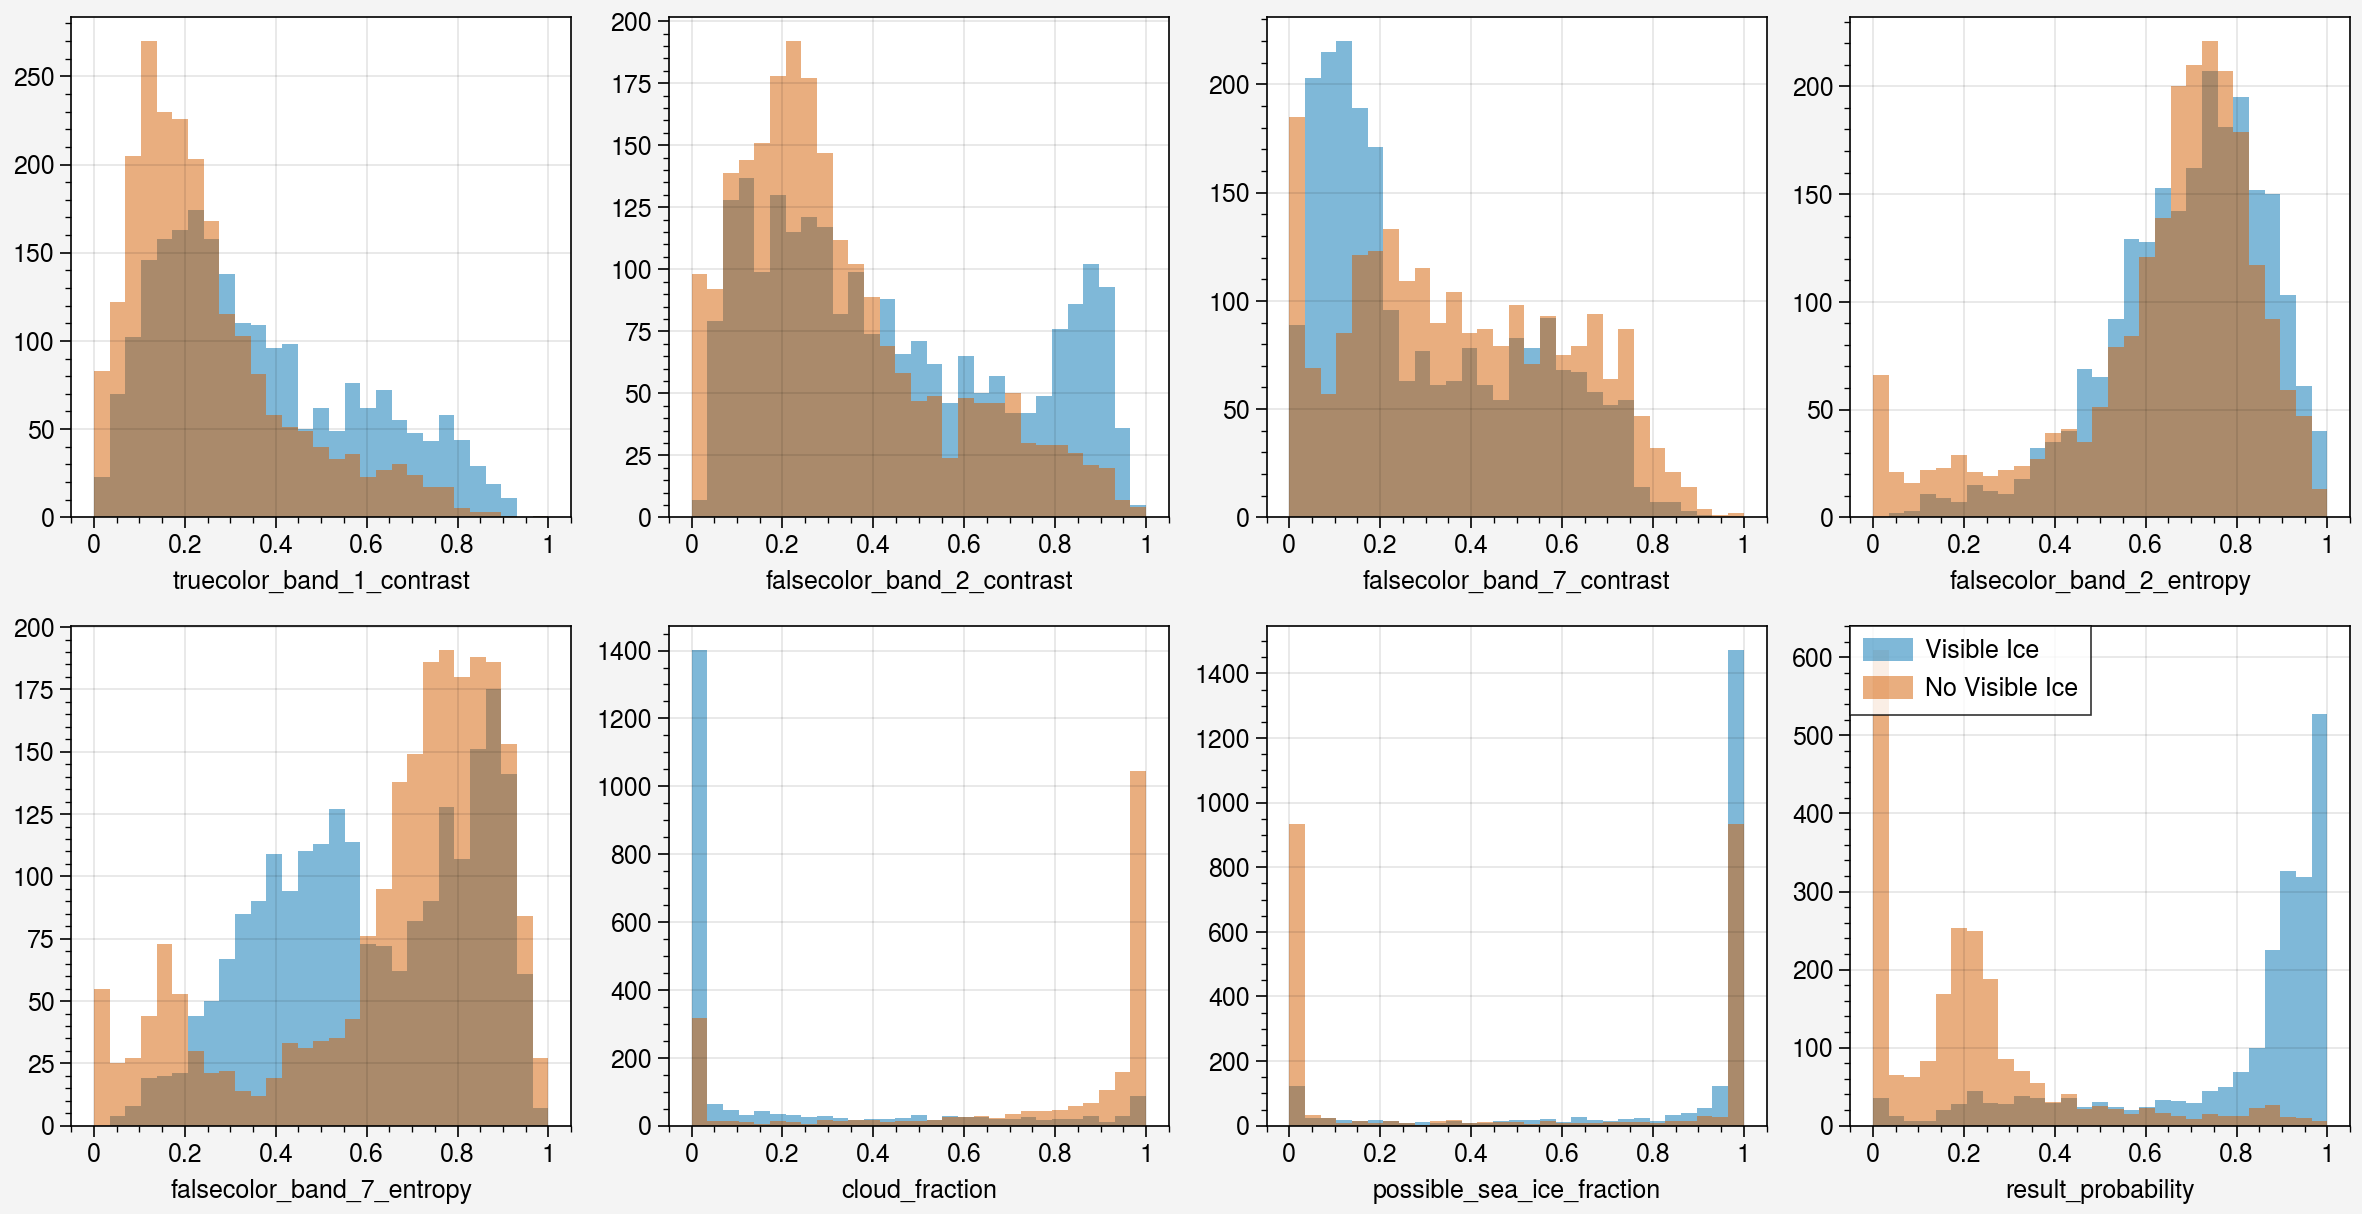

In [118]:
plot_variables = ['truecolor_band_1_contrast',  'falsecolor_band_2_contrast',
                  'falsecolor_band_7_contrast', #'truecolor_band_1_entropy',
                  'falsecolor_band_2_entropy', 'falsecolor_band_7_entropy',
                  'cloud_fraction',
                  'possible_sea_ice_fraction', 'result_probability']
fig, axs = pplt.subplots(ncols=4, nrows=2, share=False)
bins = np.linspace(0, 1, 30)
for variable, ax in zip(plot_variables, axs):
    ax.hist(df_subset.loc[df_subset.ground_truth,  variable], bins=bins, alpha=0.5, label='Visible Ice')
    ax.hist(df_subset.loc[~df_subset.ground_truth, variable], bins=bins, alpha=0.5, label='No Visible Ice')
ax.legend(ncols=1, loc='ul')

In [96]:
df_subset.head()

,ground_truth,tile_index,cloud_fraction,land_fraction,truecolor_band_1_contrast,falsecolor_band_2_contrast,falsecolor_band_7_contrast,truecolor_band_1_entropy,falsecolor_band_2_entropy,falsecolor_band_7_entropy,possible_sea_ice_fraction,region,cloudy_,result,result_probability
0,False,39,0.985,0.00000,0.397884,0.471,0.486696,0.788218,0.792546,0.785761,1.000,bering_chukchi_seas,True,False,0.298568
1,False,54,1.000,0.00000,0.153439,0.133,0.086475,0.628011,0.596008,0.563094,0.000,bering_chukchi_seas,True,False,0.013729
2,False,57,0.657,0.04735,0.231746,0.294,0.748337,0.708955,0.731257,0.934184,1.000,baffin_bay,True,False,0.408950
3,False,74,0.728,0.00000,0.622222,0.820,0.909091,0.897870,0.953277,0.958278,0.791,east_siberian_sea,True,True,0.549998
4,False,1,0.681,0.00000,0.580952,0.823,0.916851,0.899972,0.978004,1.000000,0.480,beaufort_sea,True,False,0.353894


# Cloud Fraction < 20%

F1 score:  0.886
Recall:  0.907
Precision:  0.867
Confusion matrix:
       PredTrue  PredFalse
True       0.43       0.07
False      0.05       0.45


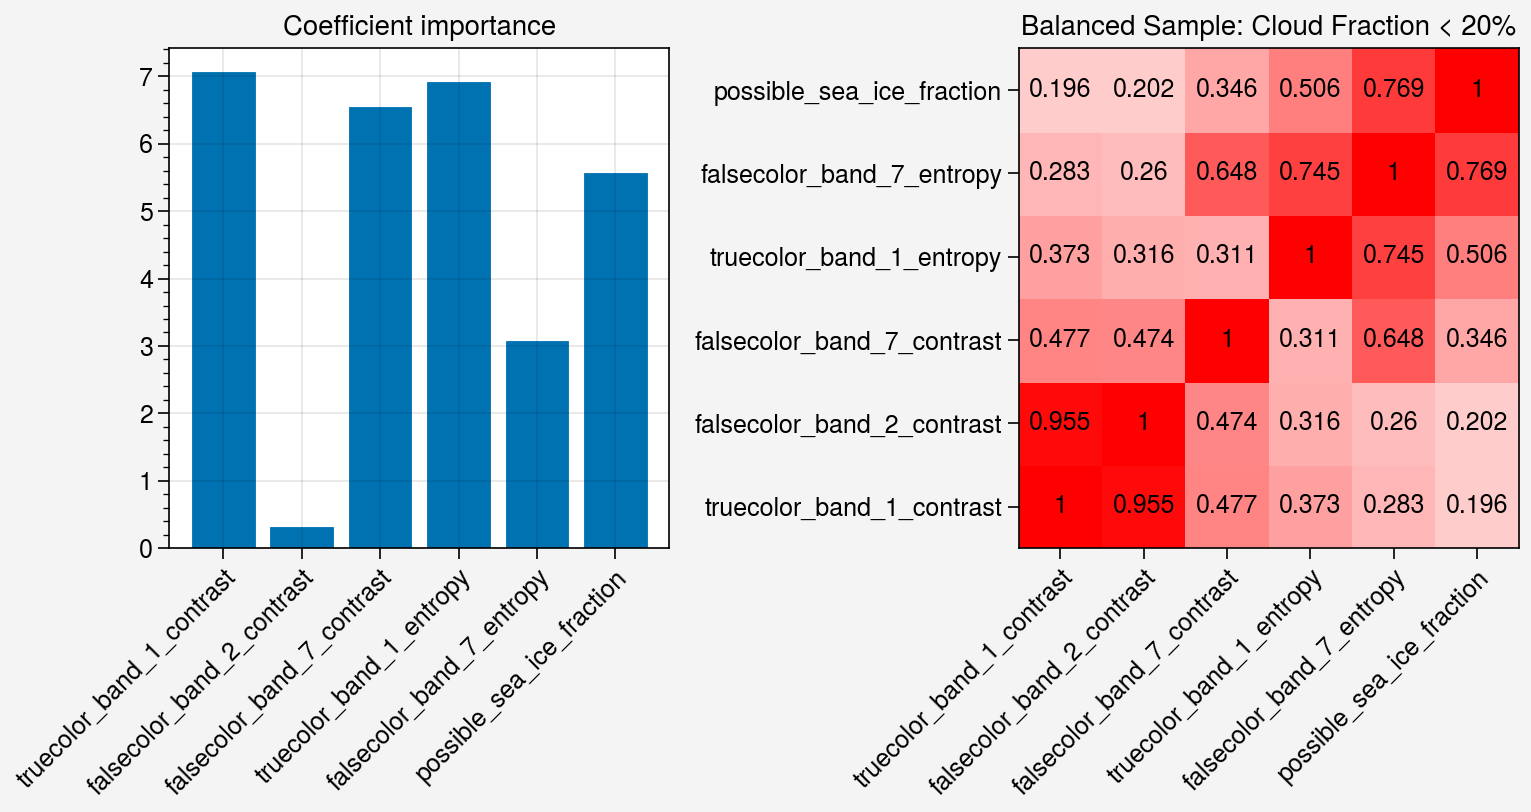

In [285]:
rs = 20250922

df = pd.concat(dataframes)
idx = (df.land_fraction <= land_threshold) & (df.cloud_fraction < 0.2)


true_cases = sum(df.loc[idx, 'ground_truth'])
false_cases = len(df.loc[idx, :]) - true_cases
n = min(true_cases, false_cases)
# Get a balanced subset of true and false cases
df_subset = df.loc[idx, :].groupby('ground_truth').apply(
    lambda x: x.sample(replace=False, n=n), include_groups=False).reset_index()
for variable in minimal_variables:
    df_subset[variable] = (df_subset[variable] - df_subset[variable].min()) / df_subset[variable].max()


#### Train logistic regression model
# Removed variables: 'falsecolor_band_2_entropy'
minimal_variables = ['truecolor_band_1_contrast',  'falsecolor_band_2_contrast',
                     'falsecolor_band_7_contrast', 'truecolor_band_1_entropy',
                     'falsecolor_band_7_entropy',
                     'possible_sea_ice_fraction']

data = df_subset.loc[:, minimal_variables + ['ground_truth']].copy()
# This are the variables that are not closely correlated with each other. Functions of other brightness channels could be useful.

X = data.loc[:, minimal_variables].to_numpy()
y =  (data.ground_truth).to_numpy()

# Split data into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=1/3, random_state=10)

# Fit the logistic regression model using cross validation
lr_model = LogisticRegressionCV(
                     solver='liblinear',
                     scoring='accuracy',
                     penalty='l1',
                     max_iter=300,
                     cv=10,
                     random_state=rs).fit(X_train, y_train)

#### Compute and print skill scores for the model
y_pred = lr_model.predict(X_test)
print('F1 score: ', np.round(f1_score(y_test, y_pred), 3))
print('Recall: ', np.round(recall_score(y_test, y_pred), 3))
print('Precision: ', np.round(precision_score(y_test, y_pred), 3))
print('Confusion matrix:')
print(pd.DataFrame(data=np.round(confusion_matrix(y_test, y_pred)/len(y_test), 2),
             index=['True', 'False'], columns=['PredTrue', 'PredFalse']))

fig, axs = pplt.subplots(ncols=2, share=False)
ax = axs[0]
ax.bar(pd.Series(abs(lr_model.coef_[0]), index=minimal_variables))
ax.format(xrotation=45, title="Coefficient importance")

ax = axs[1]
ax.heatmap(df_subset.loc[:, minimal_variables].corr(), labels=True, vmin=-1, vmax=1, cmap='bwr')
ax.format(xrotation=45, title='Balanced Sample: Cloud Fraction < 20%')

In [251]:
len(df_subset)

1248

1212
F1 score:  0.725
Recall:  0.779
Precision:  0.679
Confusion matrix:
       PredTrue  PredFalse
True       0.36       0.17
False      0.10       0.37


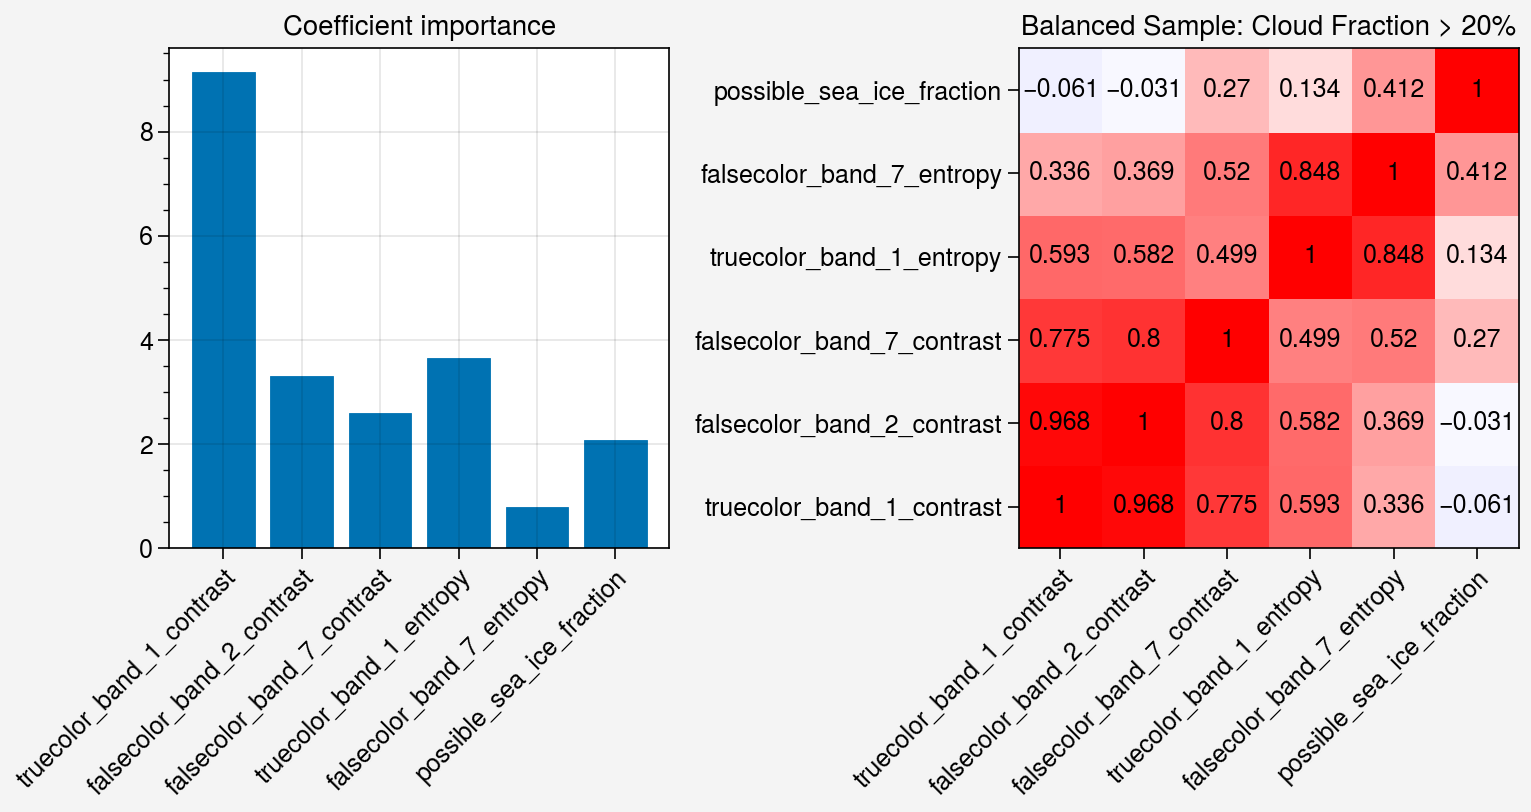

In [286]:
rs = 20250922

#### Train logistic regression model
# Removed variables: 'falsecolor_band_2_entropy'
minimal_variables = ['truecolor_band_1_contrast',  'falsecolor_band_2_contrast',
                     'falsecolor_band_7_contrast', 'truecolor_band_1_entropy',
                     'falsecolor_band_7_entropy',
                     'possible_sea_ice_fraction']

df = pd.concat(dataframes)
idx = (df.land_fraction <= land_threshold) & (df.cloud_fraction >= 0.2)
true_cases = sum(df.loc[idx, 'ground_truth'])
false_cases = len(df.loc[idx, :]) - true_cases
n = min(true_cases, false_cases)
# Get a balanced subset of true and false cases
df_subset = df.loc[idx, :].groupby('ground_truth').apply(
    lambda x: x.sample(replace=False, n=n), include_groups=False).reset_index()
for variable in minimal_variables:
    df_subset[variable] = (df_subset[variable] - df_subset[variable].min()) / df_subset[variable].max()

print(len(df_subset))


data = df_subset.loc[df_subset.cloud_fraction > 0.2, minimal_variables + ['ground_truth']].copy()
# This are the variables that are not closely correlated with each other. Functions of other brightness channels could be useful.

X = data.loc[:, minimal_variables].to_numpy()
y =  (data.ground_truth).to_numpy()

# Split data into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=1/3, random_state=10)

# Fit the logistic regression model using cross validation
lr_model = LogisticRegressionCV(
                     solver='liblinear',
                     scoring='accuracy',
                     penalty='l1',
                     max_iter=300,
                     cv=10,
                     random_state=rs).fit(X_train, y_train)

#### Compute and print skill scores for the model
y_pred = lr_model.predict(X_test)
print('F1 score: ', np.round(f1_score(y_test, y_pred), 3))
print('Recall: ', np.round(recall_score(y_test, y_pred), 3))
print('Precision: ', np.round(precision_score(y_test, y_pred), 3))
print('Confusion matrix:')
print(pd.DataFrame(data=np.round(confusion_matrix(y_test, y_pred)/len(y_test), 2),
             index=['True', 'False'], columns=['PredTrue', 'PredFalse']))

fig, axs = pplt.subplots(ncols=2, share=False)
ax = axs[0]
ax.bar(pd.Series(abs(lr_model.coef_[0]), index=minimal_variables))
ax.format(xrotation=45, title="Coefficient importance")

ax = axs[1]
ax.heatmap(df_subset.loc[:, minimal_variables].corr(), labels=True, vmin=-1, vmax=1, cmap='bwr')
ax.format(xrotation=45, title='Balanced Sample: Cloud Fraction > 20%')

In [287]:
df = pd.concat(dataframes)
true_cases = sum(df.loc[idx, 'ground_truth'])
false_cases = len(df.loc[idx, :]) - true_cases
n = min(true_cases, false_cases)
# Get a balanced subset of true and false cases
df_subset = df.loc[idx, :].groupby('ground_truth').apply(
    lambda x: x.sample(replace=False, n=n), include_groups=False).reset_index()
for variable in minimal_variables:
    df_subset[variable] = (df_subset[variable] - df_subset[variable].min()) / df_subset[variable].max()


In [288]:
df_subset.loc[:, "result"] = lr_model.predict(X)
probs = lr_model.predict_proba(X)
p_false, p_true = probs[:, 0], probs[:, 1]
df_subset.loc[:,  "result_probability"] = p_true

In [289]:
minimal_variables

['truecolor_band_1_contrast',
 'falsecolor_band_2_contrast',
 'falsecolor_band_7_contrast',
 'truecolor_band_1_entropy',
 'falsecolor_band_7_entropy',
 'possible_sea_ice_fraction']

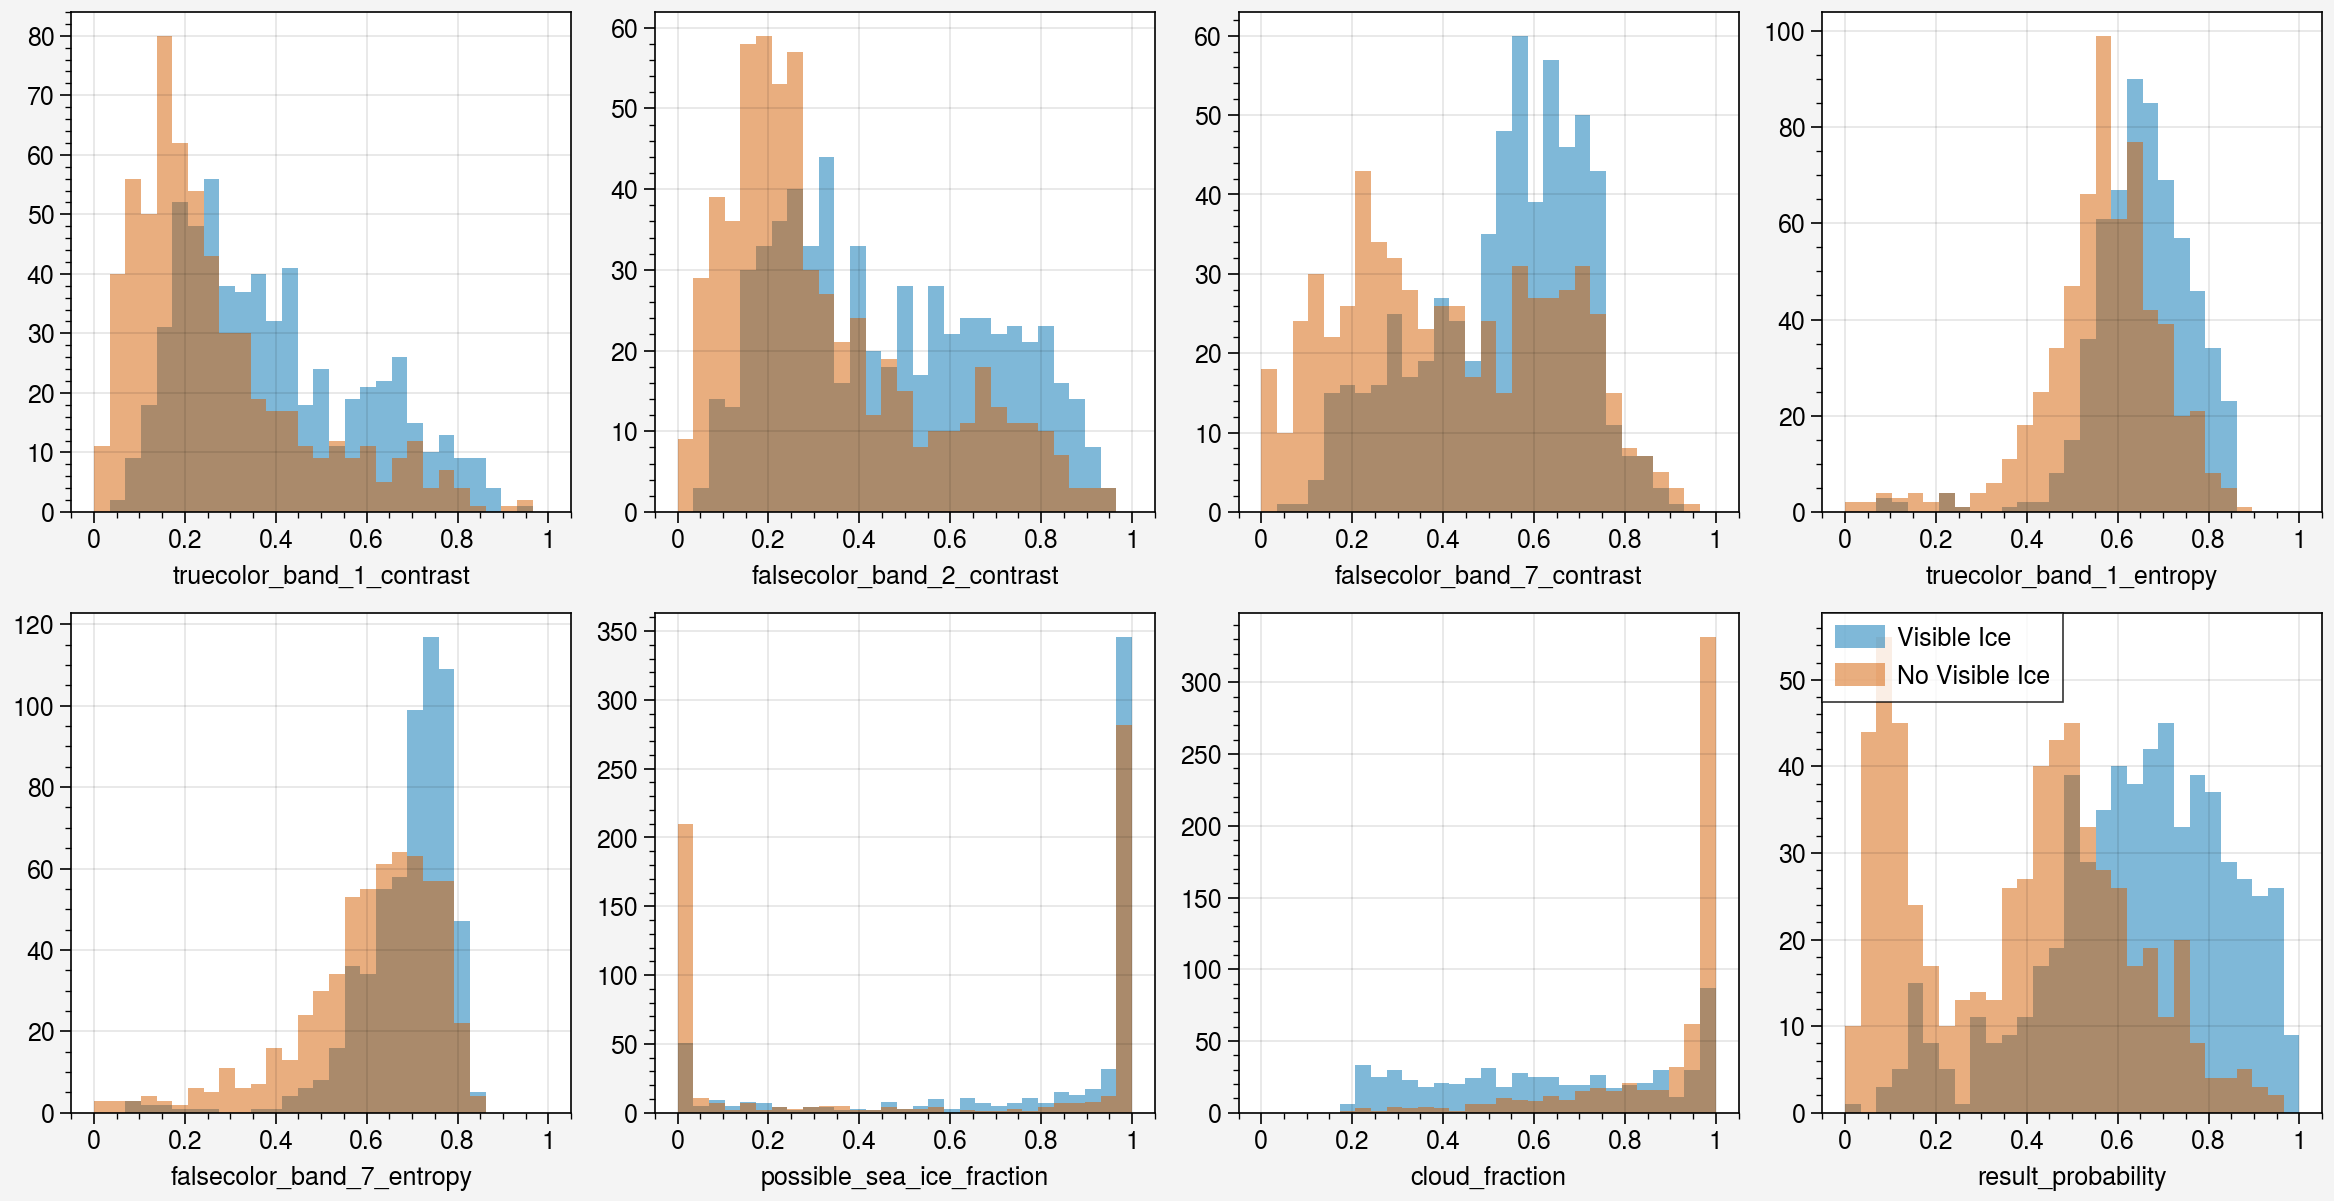

In [290]:
fig, axs = pplt.subplots(ncols=4, nrows=2, share=False)
bins = np.linspace(0, 1, 30)
for variable, ax in zip(minimal_variables + ['cloud_fraction', 'result_probability'], axs):
    ax.hist(df_subset.loc[df_subset.ground_truth,  variable], bins=bins, alpha=0.5, label='Visible Ice')
    ax.hist(df_subset.loc[~df_subset.ground_truth, variable], bins=bins, alpha=0.5, label='No Visible Ice')
ax.legend(ncols=1, loc='ul')

F1 score:  0.786
Recall:  0.783
Precision:  0.79
Confusion matrix:
       PredTrue  PredFalse
True       0.41       0.10
False      0.11       0.38


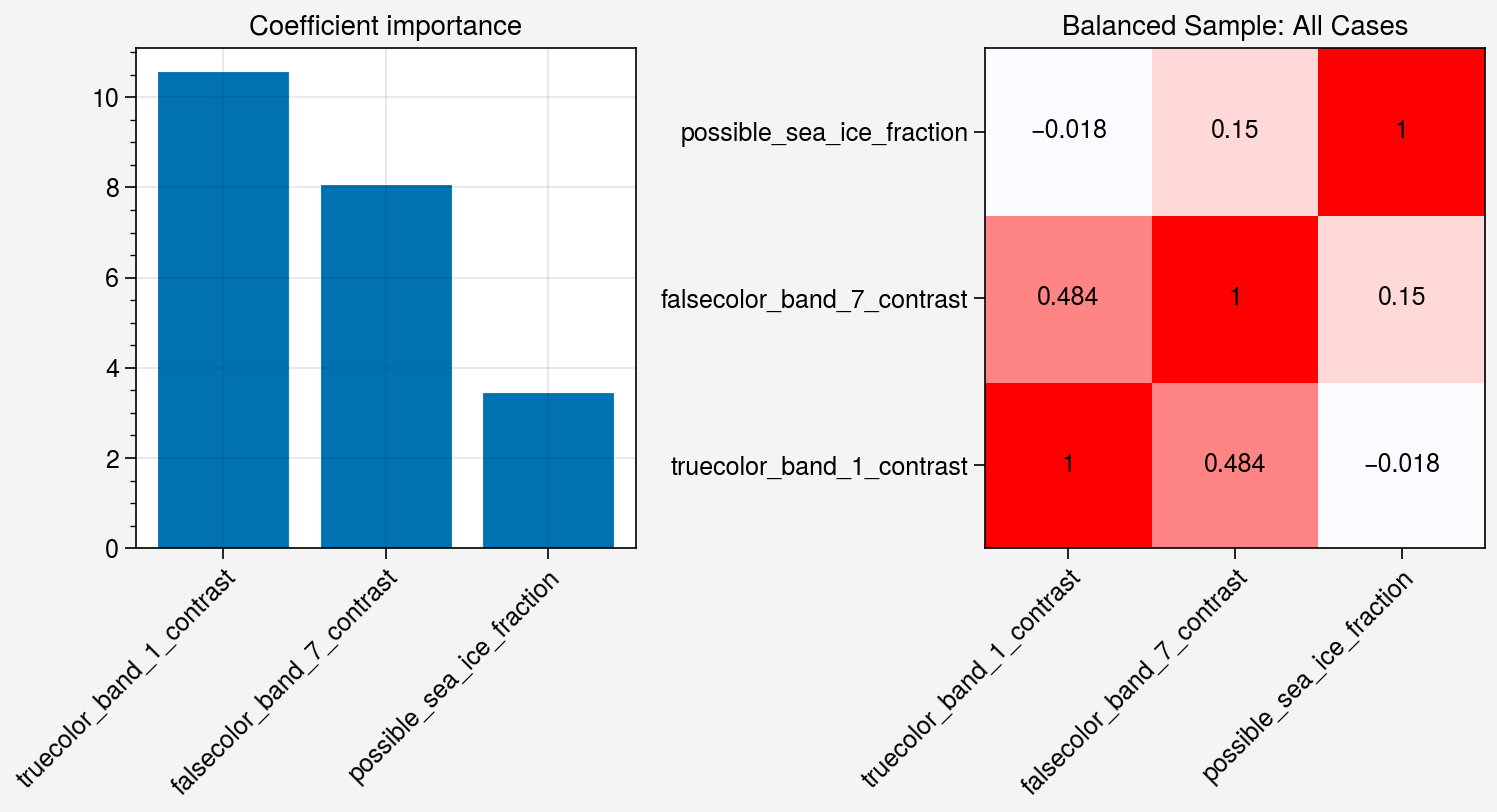

In [295]:
rs = 20250922

#### Train logistic regression model
# Removed variables: 'falsecolor_band_2_entropy'

df = pd.concat(dataframes)
idx = df.land_fraction <= land_threshold
true_cases = sum(df.loc[idx, 'ground_truth'])
false_cases = len(df.loc[idx, :]) - true_cases
n = min(true_cases, false_cases)
# Get a balanced subset of true and false cases
df_subset = df.loc[idx, :].groupby('ground_truth').apply(
    lambda x: x.sample(replace=False, n=n), include_groups=False).reset_index()
all_variables = ['truecolor_band_1_contrast',  'falsecolor_band_2_contrast',
                     'falsecolor_band_7_contrast', 'truecolor_band_1_entropy',
                     'falsecolor_band_2_entropy', 'falsecolor_band_7_entropy',
                     'possible_sea_ice_fraction']
for variable in all_variables:
    df_subset[variable] = (df_subset[variable] - df_subset[variable].min()) / df_subset[variable].max()

minimal_variables = ['truecolor_band_1_contrast',  
                     'falsecolor_band_7_contrast', 
                     'possible_sea_ice_fraction']
data = df_subset.loc[:, minimal_variables + ['ground_truth']].copy()
# This are the variables that are not closely correlated with each other. Functions of other brightness channels could be useful.

X = data.loc[:, minimal_variables].to_numpy()
y =  (data.ground_truth).to_numpy()

# Split data into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=1/3, random_state=10)

# Fit the logistic regression model using cross validation
lr_model = LogisticRegressionCV(
                     solver='liblinear',
                     scoring='accuracy',
                     penalty='l1',
                     max_iter=300,
                     cv=10,
                     random_state=rs).fit(X_train, y_train)

#### Compute and print skill scores for the model
y_pred = lr_model.predict(X_test)
print('F1 score: ', np.round(f1_score(y_test, y_pred), 3))
print('Recall: ', np.round(recall_score(y_test, y_pred), 3))
print('Precision: ', np.round(precision_score(y_test, y_pred), 3))
print('Confusion matrix:')
print(pd.DataFrame(data=np.round(confusion_matrix(y_test, y_pred)/len(y_test), 2),
             index=['True', 'False'], columns=['PredTrue', 'PredFalse']))

fig, axs = pplt.subplots(ncols=2, share=False)
ax = axs[0]
ax.bar(pd.Series(abs(lr_model.coef_[0]), index=minimal_variables))
ax.format(xrotation=45, title="Coefficient importance")

ax = axs[1]
ax.heatmap(df_subset.loc[:, minimal_variables].corr(), labels=True, vmin=-1, vmax=1, cmap='bwr')
ax.format(xrotation=45, title='Balanced Sample: All Cases')

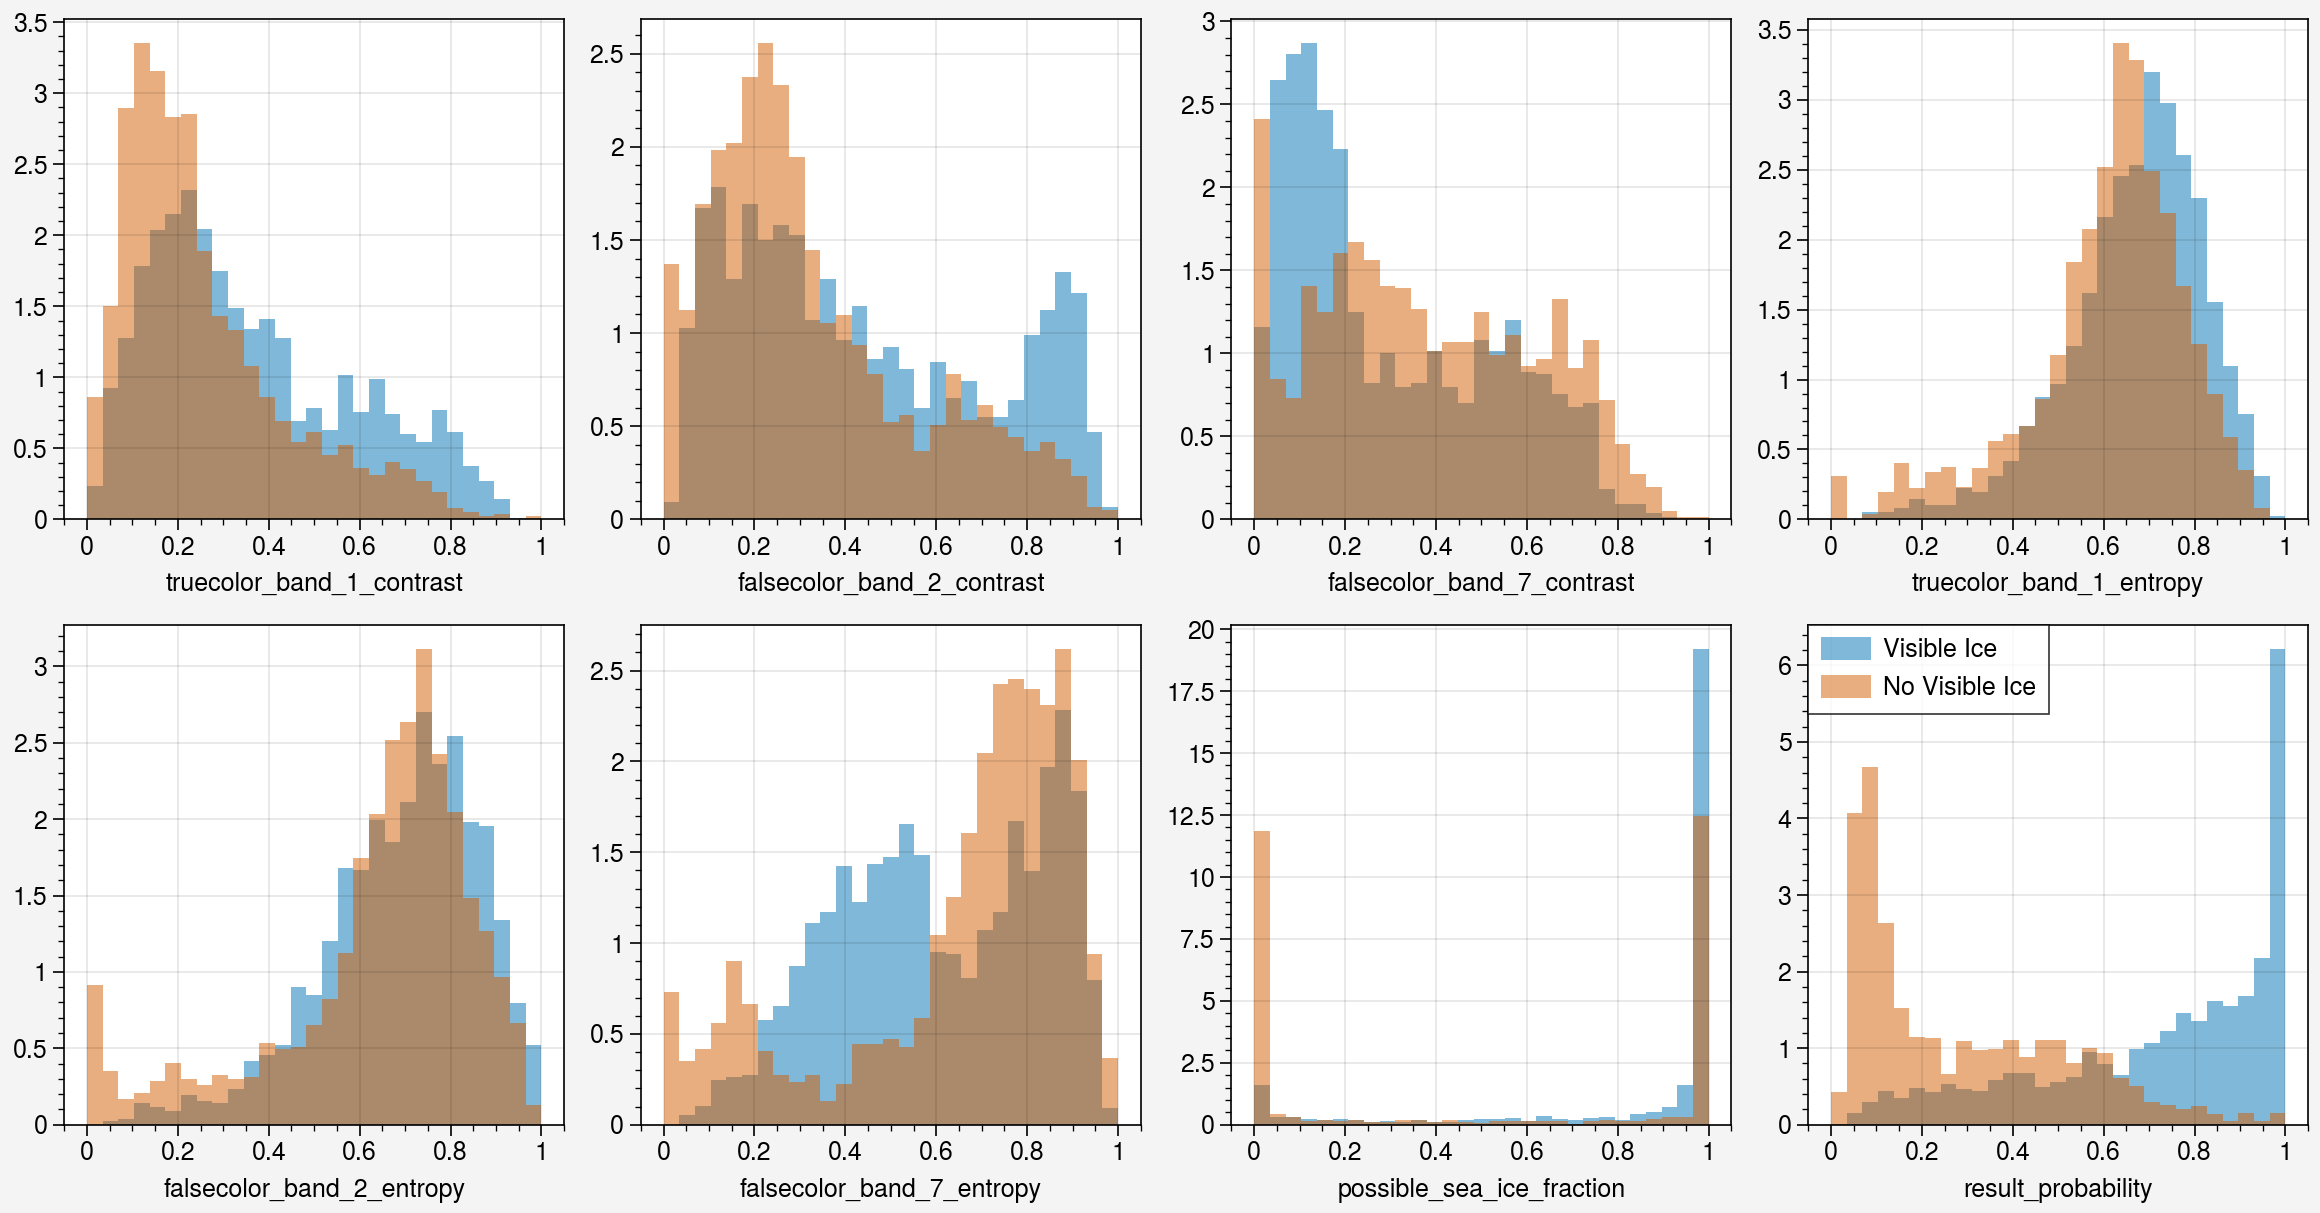

In [298]:
df_subset.loc[:, "result"] = lr_model.predict(X)
probs = lr_model.predict_proba(X)
p_false, p_true = probs[:, 0], probs[:, 1]
df_subset.loc[:,  "result_probability"] = p_true

fig, axs = pplt.subplots(ncols=4, nrows=2, share=False)
bins = np.linspace(0, 1, 30)
for variable, ax in zip(['truecolor_band_1_contrast',  'falsecolor_band_2_contrast',
                     'falsecolor_band_7_contrast', 'truecolor_band_1_entropy',
                     'falsecolor_band_2_entropy', 'falsecolor_band_7_entropy',
                     'possible_sea_ice_fraction',  'result_probability'], axs):
    ax.hist(df_subset.loc[df_subset.ground_truth,  variable], density=True, bins=bins, alpha=0.5, label='Visible Ice')
    ax.hist(df_subset.loc[~df_subset.ground_truth, variable], density=True, bins=bins, alpha=0.5, label='No Visible Ice')
ax.legend(ncols=1, loc='ul')

TBD: Clean up the approach, make sure I'm going thru the statistics appropriately. Check whether I can set the cutoff on probabilty to 0.4 and lower the false negative rate. Get function for the coefficients so that I can apply the algorithm in the Julia code.